In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [2]:
import torch
from calflops import calculate_flops
import sophius.utils as utils
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
from sophius.train import train_express_gpu
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder
from sophius.utils import calc_model_flops, hash_dict
import sqlite3
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import random
from sophius.train import train_on_gpu_ex
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    
])
cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=normalize)
cifar_gpu = dload.cifar_to_gpu(cifar10)

encoder = Encoder()

C:\Users\korol\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


In [3]:
from sophius.estimate import LSTMRegressor

estimator = torch.load('../data/models/estimator_v1.pth').cpu()

def estimate_acc(model_tmpl):
    t = torch.tensor(encoder.model2vec(model_tmpl), dtype=torch.float32)
    return estimator(t).item()

In [4]:
def read_model_db(model_id):    
    with sqlite3.connect('../data/models.db') as conn:
        hash_str = conn.execute(f'SELECT hash FROM models WHERE id==?', (model_id, )).fetchone()[0]
    return encoder.hash2model(hash_str, (3, 32, 32), 10)

read_model_db(2604)

Conv2d       (192, 16, 16)  (5, 5)   (2, 2)  
ReLU         (192, 16, 16) 
MaxPool2d    (192, 16, 16)  (3, 3)   (1, 1)  
BatchNorm2d  (192, 16, 16) 
AvgPool2d    (192, 9, 9)    (2, 2)   (2, 2)  
Conv2d       (64, 9, 9)     (3, 3)   (1, 1)  
PReLU        (64, 9, 9)    
BatchNorm2d  (64, 9, 9)    
AvgPool2d    (64, 8, 8)     (2, 2)   (1, 1)  
Conv2d       (192, 2, 2)    (7, 7)   (4, 4)  
ReLU         (192, 2, 2)   
BatchNorm2d  (192, 2, 2)   
PReLU        (192, 2, 2)   
BatchNorm2d  (192, 2, 2)   
GlobalAvgPool2d (192, 1, 1)   
Flatten      192           
Linear       10            

Conv2d       (64, 32, 32)   (7, 7)   (1, 1)  
PReLU        (64, 32, 32)  
MaxPool2d    (64, 33, 33)   (4, 4)   (1, 1)  
BatchNorm2d  (64, 33, 33)  
Conv2d       (64, 11, 11)   (1, 1)   (3, 3)  
LeakyReLU    (64, 11, 11)   (0.01)  
MaxPool2d    (64, 6, 6)     (4, 4)   (2, 2)  
BatchNorm2d  (64, 6, 6)    
Conv2d       (32, 1, 1)     (6, 6)   (2, 2)  
ReLU         (32, 1, 1)    
GlobalAvgPool2d (32, 1, 1)    
Flatten      32            
Linear       10            



Loss 18.405: 100%|██████████| 50/50 [02:38<00:00,  3.17s/it]


val_acc: 0.690 train_acc: 0.957
val_acc* 0.691


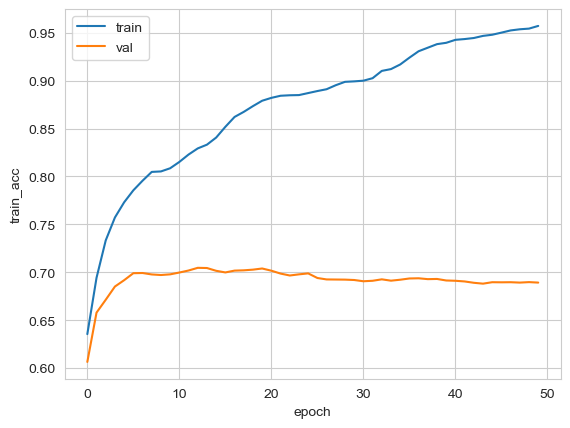

In [50]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), 
    out_shape=10, 
    conv_num=3, 
    lin_num=1,
)

model_tmpl = model_gen.generate_model_tmpl()
# model_tmpl = read_model_db(2604)

model = model_tmpl.instantiate_model().type(torch.cuda.FloatTensor)

print(model_tmpl)

val_acc_threshold = 0.6

train_params = {
    'val_size': 10000,
    'batch_size': 256,
    'num_epoch': 50,
    'random_seed':42,
    'optimizer': 'AdamW',
    'opt_params': {
        'lr': 1e-3,
    },
    'scheduler': 'ExponentialLR',
    'sch_params': {
        'gamma': 0.95,
    },
}

res = train_on_gpu_ex(
    model=model,
    dataset=cifar_gpu,
    verbose=True,
    **train_params,
)
print('val_acc* %.3f' % (estimate_acc(model_tmpl)))

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val');

In [53]:
import sqlite3
from sophius.utils import hash_dict

exp_tbl_name = 'experiments'

exp_params = {**train_params, **{'in_shape': (3, 32, 32), 'out_shape': 10, }}

def exp_to_df(exp_params: dict, exp_id: int) -> pd.DataFrame:
    df = pd.DataFrame([exp_params], index=[exp_id])
    df.index.name = 'id'
    exp_hash = hash_dict(exp_params)
    df['hash'] = exp_hash
    
    # cast complex objects to string
    for col in ['opt_params', 'sch_params', 'in_shape', 'out_shape']:
        df[col] = df[col].astype(str)
    return df    

def tbl_exists(tbl_name, conn):
    sql = ("SELECT name FROM sqlite_master "
           f"WHERE type='table' AND name='{tbl_name}'")
    return conn.execute(sql).fetchone() is not None

def get_new_exp_id(conn: sqlite3.Connection):
    try:
        return conn.execute(f'SELECT COUNT(*) FROM {exp_tbl_name}').fetchone()[0]
    except:
        return 0
    
def search_experiment(conn: sqlite3.Connection, exp_params: dict):    
    exp_hash = hash_dict(exp_params)
    res = conn.execute(f'SELECT id FROM {exp_tbl_name} WHERE hash == ?', (exp_hash,)).fetchone()
    if res:
        return res[0]
    return None

def add_experiment(exp_params: dict, db_path='../data/models.db'):
    with sqlite3.connect(db_path) as conn:                
        # check if experiment table exists
        if not tbl_exists(exp_tbl_name, conn):
            print(f'Creating {exp_tbl_name} table')
            exp_id = 0
            exp_df = exp_to_df(exp_params, exp_id)
            exp_df.to_sql(exp_tbl_name, conn, if_exists='append')
            return exp_id

        # check if experiment exists                
        exp_id = search_experiment(conn, exp_params)
        
        if exp_id is not None:
            print('Experiment exists')
            print(exp_params)
        else:
            print('Adding new experiment')
            exp_id = get_new_exp_id(conn)
            exp_df = exp_to_df(exp_params, exp_id)
            exp_df.to_sql(exp_tbl_name, conn, if_exists='append')
    return exp_id

exp_id = add_experiment(exp_params)

Experiment exists
{'val_size': 10000, 'batch_size': 256, 'num_epoch': 50, 'random_seed': 42, 'optimizer': 'AdamW', 'opt_params': {'lr': 0.001}, 'scheduler': 'ExponentialLR', 'sch_params': {'gamma': 0.95}, 'in_shape': (3, 32, 32), 'out_shape': 10}


In [ ]:
def get_new_model_id(db_path='../data/models.db'):
    with sqlite3.connect(db_path) as conn:
        try:
            return conn.execute('SELECT COUNT(*) FROM models').fetchone()[0]
        except:
            return 0

In [15]:
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=3, lin_num=1)
estimator = torch.load('../data/models/estimator_v2.pth').cpu()
val_acc_threshold = 0.7

for i in tqdm(range(100)):
    model_tmpl = model_gen.generate_model_tmpl()    
    model = model_tmpl.instantiate_model().type(torch.cuda.FloatTensor)
    
    est_val_acc = estimate_acc(model_tmpl) 
    if est_val_acc < val_acc_threshold:
        # print('Skip %.3f' % est_val_acc)
        continue
    print('Pass %.3f' % est_val_acc)
    
    epoch_results = train_on_gpu_ex(
        model=model,
        dataset=cifar_gpu,
        verbose=False,
        **train_params,
    )
    
    model_id = get_new_model_id()
        
    model_results = calc_model_flops(model, (3, 32, 32))
    model_results['id'] = model_id
    model_results['exp_id'] = exp_id
    model_results['hash'] = encoder.model2hash(model_tmpl)    
    model_results['val_acc'] = epoch_results.val_acc.iloc[-10:].mean()
    model_results['train_acc'] = epoch_results.train_acc.iloc[-10:].mean()
    model_results['time'] = epoch_results.time.iloc[-1]
    
    epoch_results['model_id'] = model_id
    epoch_results['exp_id'] = exp_id

    with sqlite3.connect('../data/models.db') as conn:
        df = pd.DataFrame([model_results]).set_index('id') 
        df.to_sql('test_models', conn, if_exists='append')
        
        epoch_results.to_sql('test_model_epochs', conn, if_exists='append', index=False)
        
#     # print(df.loc[i])

 48%|████▊     | 48/100 [00:00<00:00, 200.42it/s]

Pass 0.737
Pass 0.703
Pass 0.718
Pass 0.738
Pass 0.726
Pass 0.794


100%|██████████| 100/100 [00:00<00:00, 197.79it/s]

Pass 0.710
